# Homework and bake-off: pragmatic color descriptions

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Summer 2022"

import os

if 'IS_GRADESCOPE_ENV' not in os.environ:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/gdrive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    FOLDERNAME = 'Shareddrives/CS224U/cs224u'
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append('/content/gdrive/{}'.format(FOLDERNAME))

    %cd /content/gdrive/$FOLDERNAME

Mounted at /content/gdrive
/content/gdrive/Shareddrives/CS224U/cs224u


In [2]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_color_describer import ContextualColorDescriber
from torch_color_describer import create_example_dataset

import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [3]:
utils.fix_random_seeds()

In [4]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [5]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    normalize_colors=True)

In [6]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [7]:
len(dev_examples)

46994

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [8]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [9]:
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
    train_test_split(dev_rawcols, dev_texts)

#dev_rawcols_test, dev_rawcols_train = dev_rawcols[:3473], dev_rawcols[3473:]
#dev_texts_test, dev_texts_train = dev_texts[:3473], dev_texts[3473:]

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [10]:
def tokenize_example(s, vocab = None):
    import string
    import re
    
    endings = ["er", "est", "ish"]

    s = s.lower()
    r = re.compile(r'[\s{}]+'.format(re.escape(string.punctuation)))
    words = r.split(s)
    split = []
    
    for w in words:
        if w[-2:] == "er":
            w = w[:-2]
        elif w[-3:] == "est" or w[-3:] == "ish":
            w = w[:-3]

        if vocab is not None:
            if w not in vocab:
                w = w.replace(w, '$UNK')

        if w != '':
            split.append(w)
        
    return [START_SYMBOL] + split + [END_SYMBOL]

In [11]:
tokenize_example(dev_texts_train[376])

['<s>', 'aqua', '</s>']

__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [12]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."

In [13]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

In [14]:
#Standard dev_vocab method
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})

#Remove words that only appear once
#from collections import Counter
#count_dict = Counter([w for toks in dev_seqs_train for w in toks])
#dev_vocab = sorted({tok for tok, count in count_dict.items() if count > 1})

#Replace all words that only appear once in training set with UNK_SYMBOL
dev_seqs_train = [tokenize_example(s, dev_vocab) for s in dev_texts_train]

dev_vocab += [UNK_SYMBOL]

In [15]:
len(dev_vocab)

2553

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [16]:
def represent_color_context(colors):

    return [represent_color(color) for color in colors]

def represent_color(color):
    from itertools import product
    
    color0 = color[0]
    color1 = color[1]
    color2 = color[2]
    
    h = color0 
    v = color1 + color2 * min(color1, 1 - color1)
    if v == 0:
        s = 0
    else:
        s = 2 * (1 - color1 / v)
    color_rep = np.zeros((3, 3, 3, 2))

    for j, k, l in product((0, 1, 2), repeat=3):    
        f_hat = np.exp(-2 * np.pi * complex(0, (j * h + k * s + l * v)))
        color_rep[j, k, l, 0] = f_hat.real
        color_rep[j, k, l, 1] = f_hat.imag
    
    return color_rep.transpose(3, 0, 1, 2).flatten().tolist()

In [17]:
def test_represent_color_context(func):
    """`func` should be `represent_color_context`"""
    example = [
        [0.786, 0.58, 0.87],
        [0.689, 0.44, 0.92],
        [0.628, 0.32, 0.81]]
    result = func(example)
    assert len(result) == len(example), \
        ("Color context representations need to represent each color "
         "separately. (We assume the final color is the target.)")
    for i, color in enumerate(result):
        assert all(isinstance(x, float) for x in color), \
            ("All color representations should be lists of floats. "
             "Color {} is {}".format(i, color))

In [18]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

## Initial model

The first model is configured right now to be a small model run for just a few iterations. It should be enough to get traction, but it's unlikely to be a great model. You are free to modify this configuration if you wish; it is here just for demonstration and testing:

In [19]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    early_stopping=True,
    batch_size = 256)

In [20]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %time _ = dev_mod.fit(dev_cols_train, dev_seqs_train)
else:
    dev_mod.fit(dev_cols_train, dev_seqs_train)

/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  color_seqs = torch.FloatTensor(color_seqs)
/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 859.6333932876587


 Best Score: 0.4258156028368794


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 794.7774720191956


 Best Score: 0.5378723404255319


KeyboardInterrupt: ignored

The canonical bake-off evaluation function is `evaluate`. Our primary metric is `listener_accuracy`; the BLEU score is included as a check to ensure that your system is speaking English!

In [ ]:
evaluation = dev_mod.evaluate(dev_cols_test[:], dev_seqs_test[:])

In [ ]:
evaluation.keys()

In [ ]:
evaluation['listener_accuracy']

In [ ]:
dev_mod.listener_accuracy(dev_cols_test, dev_seqs_test)

In [ ]:
evaluation['corpus_bleu']

In [ ]:
bleu, predicted_utterances = dev_mod.corpus_bleu(dev_cols_test, dev_seqs_test)

bleu

In [ ]:
evaluation['target_index'][: 5]

In [ ]:
evaluation['predicted_index'][: 5]

In [ ]:
evaluation['predicted_utterance'][: 5]

We can also see the model's predicted sequences given color context inputs:

In [ ]:
dev_mod.predict(dev_cols_test[: 1])

In [ ]:
dev_seqs_test[: 1]

## Question 3: GloVe embeddings [1 point]

The above model uses a random initial embedding, as configured by the decoder used by `ContextualColorDescriber`. This homework question asks you to consider using GloVe inputs. 

__Your task__: Complete `create_glove_embedding` so that it creates a GloVe embedding based on your model vocabulary. This isn't meant to be analytically challenging, but rather just to create a basis for you to try out other kinds of rich initialization.

In [19]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

In [20]:
def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):
    # Use `utils.glove2dict` to read in the GloVe file:

    ##### YOUR CODE HERE
    data = utils.glove2dict(os.path.join(GLOVE_HOME, glove_base_filename))


    # Use `utils.create_pretrained_embedding` to create the embedding.
    # This function will, by default, ensure that START_TOKEN,
    # END_TOKEN, and UNK_TOKEN are included in the embedding.

    ##### YOUR CODE HERE
    embedding, vocab = utils.create_pretrained_embedding(data, vocab)


    # Be sure to return the embedding you create as well as the
    # vocabulary returned by `utils.create_pretrained_embedding`,
    # which is likely to have been modified from the input `vocab`.

    ##### YOUR CODE HERE
    return embedding, vocab

In [21]:
def test_create_glove_embedding(func):
    vocab = ['NLU', 'is', 'the', 'future', '.', '$UNK', '<s>', '</s>']
    glove_embedding, glove_vocab = func(vocab, 'glove.6B.50d.txt')
    assert isinstance(glove_embedding, np.ndarray), \
        "Expected embedding type {}; got {}".format(
        glove_embedding.__class__.__name__, glove_embedding.__class__.__name__)
    assert glove_embedding.shape == (8, 50), \
        "Expected embedding shape (8, 50); got {}".format(glove_embedding.shape)
    assert glove_vocab == vocab, \
        "Expected vocab {}; got {}".format(vocab, glove_vocab)

In [22]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_create_glove_embedding(create_glove_embedding)

## Try the GloVe representations

The extent to which GloVe is useful will depend heavily on how aligned your tokenization scheme is with the GloVe vocabulary. For example, if you did character-level tokenization, then the GloVe embedding space is not well-aligned with your tokenizer and using GloVe should have little no positive effect.

Let's see if GloVe helped for our development data:

In [23]:
dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)

In [24]:
len(dev_vocab)

2553

In [25]:
len(dev_glove_vocab)

2553

In [26]:
dev_mod_glove = ContextualColorDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True,
    save_csv = 'logs/glove_baseline.csv')

In [ ]:
 %time _ = dev_mod_glove.fit(dev_cols_train[:], dev_seqs_train[:])

/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  color_seqs = torch.FloatTensor(color_seqs)
/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 240.61629009246826


 Best Score: 0.43120567375886526


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 225.3266158103943/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 217.53628301620483


 Best Score: 0.43432624113475177


In [ ]:
 #Fit on all data for testing 
 %time _ = dev_mod_glove.fit(dev_cols_train, dev_seqs_train)

/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 240.52649641036987


 Best Score: 0.38638297872340427


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 226.0623655319214


 Best Score: 0.4272340425531915


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 218.3308506011963/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 214.9611530303955/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 213.02320337295532


 Best Score: 0.43319148936170215


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 210.64723777770996


 Best Score: 0.4621276595744681


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 208.9399127960205


 Best Score: 0.49645390070921985


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 207.3242063522339


 Best Score: 0.5341843971631206


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 205.71507596969604


 Best Score: 0.5895035460992908


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 203.4258041381836


 Best Score: 0.6289361702127659


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 201.74607753753662


 Best Score: 0.6686524822695036


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 199.29748725891113


 Best Score: 0.6975886524822695


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 197.52209186553955


 Best Score: 0.72


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 196.38006782531738


 Best Score: 0.7350354609929078


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 193.1101098060608


 Best Score: 0.7512056737588653


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 191.92311573028564


 Best Score: 0.7668085106382979


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 190.99436140060425


 Best Score: 0.7767375886524823


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 188.34587860107422


 Best Score: 0.7858156028368795


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 186.60783910751343


 Best Score: 0.7934751773049645


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 186.27330827713013


 Best Score: 0.7937588652482269


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 182.92431020736694


 Best Score: 0.7940425531914893


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 182.11843585968018


 Best Score: 0.7974468085106383


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 180.66557359695435


 Best Score: 0.8014184397163121


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 178.20998859405518


 Best Score: 0.8031205673758866


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 177.37217092514038/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 174.33625507354736


 Best Score: 0.8042553191489362


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 173.97717332839966


 Best Score: 0.8045390070921986


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 172.0294861793518/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 169.93566417694092


 Best Score: 0.8116312056737589


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 169.11299324035645/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 166.5034956932068


 Best Score: 0.813049645390071


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 165.04666900634766


 Best Score: 0.8147517730496454


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 163.9034194946289


 Best Score: 0.8158865248226951


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 161.95043468475342


 Best Score: 0.8187234042553192


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 160.00707530975342/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 159.03426361083984


 Best Score: 0.8198581560283688


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 37 of 1000; error is 157.50899505615234


 Best Score: 0.8226950354609929


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 38 of 1000; error is 155.72734260559082


 Best Score: 0.8252482269503546


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 39 of 1000; error is 153.7620930671692/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 40 of 1000; error is 152.10663032531738


 Best Score: 0.8286524822695035


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 41 of 1000; error is 150.2268099784851


 Best Score: 0.8300709219858156


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 42 of 1000; error is 148.78528261184692


 Best Score: 0.8314893617021276


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 43 of 1000; error is 147.50566577911377


 Best Score: 0.8323404255319149


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 44 of 1000; error is 146.296621799469/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 45 of 1000; error is 144.27528619766235/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 46 of 1000; error is 142.71201038360596


 Best Score: 0.8343262411347517


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 47 of 1000; error is 141.27702379226685/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 48 of 1000; error is 139.06689882278442/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 49 of 1000; error is 138.4232349395752


 Best Score: 0.8348936170212766


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 50 of 1000; error is 136.86478757858276/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 51 of 1000; error is 134.0032606124878/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 52 of 1000; error is 132.82495069503784


 Best Score: 0.8365957446808511


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 53 of 1000; error is 131.6686954498291/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 54 of 1000; error is 129.7963240146637


 Best Score: 0.8374468085106384


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 55 of 1000; error is 128.57249307632446/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 56 of 1000; error is 125.87114095687866


 Best Score: 0.84


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 57 of 1000; error is 125.21286797523499


 Best Score: 0.8422695035460993


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 58 of 1000; error is 122.88412976264954/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 59 of 1000; error is 122.296879529953


 Best Score: 0.8451063829787234


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 60 of 1000; error is 120.3881585597992/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 61 of 1000; error is 118.78116655349731


 Best Score: 0.8462411347517731


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 62 of 1000; error is 117.32684063911438


 Best Score: 0.8465248226950355


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 63 of 1000; error is 115.93447852134705


 Best Score: 0.8468085106382979


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 64 of 1000; error is 114.3587532043457


 Best Score: 0.8470921985815603


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 65 of 1000; error is 112.31860542297363/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 66 of 1000; error is 111.12279343605042


 Best Score: 0.8482269503546099


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 67 of 1000; error is 109.67013216018677/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 68 of 1000; error is 108.07494354248047/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 69 of 1000; error is 106.04421496391296


 Best Score: 0.8490780141843972


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 70 of 1000; error is 104.84536647796631/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 71 of 1000; error is 103.50426840782166/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 72 of 1000; error is 101.87547159194946


 Best Score: 0.849645390070922


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 73 of 1000; error is 100.3857798576355/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 74 of 1000; error is 98.70092844963074/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 75 of 1000; error is 97.21896481513977


 Best Score: 0.8499290780141844


/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 76 of 1000; error is 95.52199363708496/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 77 of 1000; error is 94.2405571937561/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 78 of 1000; error is 92.67695188522339/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 79 of 1000; error is 91.16562604904175/content/gdrive/Shareddrives/CS224U/cs224u/torch_color_describer.py:681: RuntimeWarni

CPU times: user 16min 40s, sys: 5.86 s, total: 16min 46s
Wall time: 16min 44s


In [ ]:
evaluation = dev_mod_glove.evaluate(dev_cols_test[:], dev_seqs_test[:])

In [ ]:
evaluation['listener_accuracy']

In [ ]:
evaluation['corpus_bleu']

In [ ]:
corpus = dev_corpus.read()

for i in range(20):
  ex = next(corpus)
  ex.display()

In [ ]:
evaluation['predicted_utterance'][: 20]

In [ ]:
evaluation['predicted_index'][:20]

In [ ]:
dev_mod_glove.to_pickle('models/dev_glove.pkl')

## Try BERT Embeddings

In [ ]:
! pip install -r requirements.txt
! pip install datasets

     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x3120000 @  0x7fa471ef2615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 16 kB/s 
     |████████████████████████████████| 23.3 MB 51.3 MB/s 
     |████████████████████████████████| 3.8 MB 40.9 MB/s 
     |████████████████████████████████| 325 kB 53.5 MB/s 
     |████████████████████████████████| 181 kB 39.9 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 6.6 MB 34.6 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 880 kB 53.6 MB/s 
     |████████████████████████████████| 212 kB 44.7 MB/s 
     |██████

In [ ]:
from transformers import BertModel, BertTokenizer

bert_weights_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
bert_model = BertModel.from_pretrained(bert_weights_name)

import vsm

dev_bert_embedding_df = vsm.create_subword_pooling_vsm(dev_vocab, bert_tokenizer, bert_model, layer=1)

dev_bert_embedding = np.array(dev_bert_embedding_df)
dev_bert_vocab = list(dev_bert_embedding_df.index)
print(dev_bert_embedding[: 5, :10])
dev_bert_embedding_df.iloc[: 5, :10]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[ 0.01273496  0.2598525   0.05562858 -0.6242962   0.52302974 -0.39368033
  -0.13994865 -0.6028197   0.03256238 -0.7281731 ]
 [-0.16912864 -0.32713804 -0.09893528 -0.79884493 -0.13777366 -0.40770313
   0.01709762 -0.9666364   0.17770827 -0.47439516]
 [ 1.0603111  -0.23800062 -0.44365168 -0.33746207 -0.16627415 -0.21830165
  -0.052866    0.08816504 -0.11985715 -0.33110657]
 [ 1.2455245  -0.25233263 -0.26108843 -0.5514601  -0.4135048  -0.2172085
  -0.2696911  -0.06361141 -0.18361767 -0.605776  ]
 [ 0.10363148  0.38451084 -0.3117863   0.08180621 -0.03740378  0.04219696
  -0.0983355  -0.19672818  0.15673356 -0.08154956]]


,0,1,2,3,4,5,6,7,8,9
10,0.012735,0.259852,0.055629,-0.624296,0.523030,-0.393680,-0.139949,-0.602820,0.032562,-0.728173
2,-0.169129,-0.327138,-0.098935,-0.798845,-0.137774,-0.407703,0.017098,-0.966636,0.177708,-0.474395
</s>,1.060311,-0.238001,-0.443652,-0.337462,-0.166274,-0.218302,-0.052866,0.088165,-0.119857,-0.331107
<s>,1.245525,-0.252333,-0.261088,-0.551460,-0.413505,-0.217209,-0.269691,-0.063611,-0.183618,-0.605776
a,0.103631,0.384511,-0.311786,0.081806,-0.037404,0.042197,-0.098335,-0.196728,0.156734,-0.081550


In [ ]:
dev_mod_bert = ContextualColorDescriber(
    dev_bert_vocab,
    embedding=dev_bert_embedding,
    early_stopping=True)

_ = dev_mod_bert.fit(dev_cols_train, dev_seqs_train)

Finished epoch 1 of 1000; error is 57.31364631652832


 Best Score: 0.35892514395393477


Finished epoch 3 of 1000; error is 48.10073709487915


 Best Score: 0.3714011516314779


Finished epoch 6 of 1000; error is 43.324517011642456


 Best Score: 0.3723608445297505


Finished epoch 7 of 1000; error is 43.413930892944336


 Best Score: 0.3800383877159309


Finished epoch 8 of 1000; error is 42.06294918060303


 Best Score: 0.3809980806142035


Finished epoch 12 of 1000; error is 40.825116872787476


 Best Score: 0.4088291746641075


Finished epoch 13 of 1000; error is 39.69535565376282


 Best Score: 0.41746641074856045


Finished epoch 14 of 1000; error is 40.4001567363739


 Best Score: 0.42802303262955854


Finished epoch 15 of 1000; error is 40.17532205581665


 Best Score: 0.44817658349328215


Finished epoch 16 of 1000; error is 40.84863042831421


 Best Score: 0.45777351247600767


Finished epoch 17 of 1000; error is 39.797876596450806


 Best Score: 0.4750479846449136


Finished epoch 20 of 1000; error is 39.213024616241455


 Best Score: 0.47888675623800386


Finished epoch 21 of 1000; error is 39.90838432312012


 Best Score: 0.4836852207293666


Finished epoch 22 of 1000; error is 37.95148754119873


 Best Score: 0.4884836852207294


Finished epoch 23 of 1000; error is 38.71275472640991


 Best Score: 0.5


Finished epoch 24 of 1000; error is 38.48892879486084


 Best Score: 0.5038387715930902


Finished epoch 25 of 1000; error is 38.248011350631714


 Best Score: 0.510556621880998


Finished epoch 26 of 1000; error is 38.97919750213623


 Best Score: 0.5134357005758158


Finished epoch 27 of 1000; error is 37.915385246276855


 Best Score: 0.517274472168906


Finished epoch 28 of 1000; error is 38.1712908744812


 Best Score: 0.5201535508637236


Finished epoch 29 of 1000; error is 37.57225322723389


 Best Score: 0.5316698656429942


Finished epoch 30 of 1000; error is 36.92641067504883


 Best Score: 0.5355086372360844


Finished epoch 31 of 1000; error is 38.14505934715271


 Best Score: 0.5441458733205374


Finished epoch 32 of 1000; error is 37.16701126098633


 Best Score: 0.5518234165067178


Finished epoch 33 of 1000; error is 37.055087089538574


 Best Score: 0.5575815738963532


Finished epoch 34 of 1000; error is 37.71059012413025


 Best Score: 0.5595009596928983


Finished epoch 37 of 1000; error is 36.40307950973511


 Best Score: 0.5614203454894434


Finished epoch 38 of 1000; error is 35.31373310089111


 Best Score: 0.5681381957773513


Finished epoch 40 of 1000; error is 36.038796186447144


 Best Score: 0.5882917466410749


Finished epoch 43 of 1000; error is 35.62065362930298


 Best Score: 0.5959692898272553


Finished epoch 44 of 1000; error is 35.039759397506714


 Best Score: 0.5969289827255279


Finished epoch 46 of 1000; error is 36.054813861846924


 Best Score: 0.5978886756238004


Finished epoch 47 of 1000; error is 35.054861307144165


 Best Score: 0.5988483685220729


Finished epoch 51 of 1000; error is 34.603320598602295


 Best Score: 0.5998080614203455


Finished epoch 52 of 1000; error is 34.44709086418152


 Best Score: 0.6036468330134357


Finished epoch 54 of 1000; error is 34.25067448616028


 Best Score: 0.6142034548944337


Finished epoch 55 of 1000; error is 34.107524156570435


 Best Score: 0.6161228406909789


Stopping after epoch 66. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 32.7342574596405

In [ ]:
evaluation = dev_mod_bert.evaluate(dev_cols_test[:], dev_seqs_test[:])

In [ ]:
evaluation['listener_accuracy']

0.6075439101641232

In [ ]:
evaluation['corpus_bleu']

0.6947333833047478

Medium pink
Mint green.
Mud brown


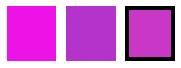

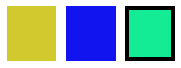

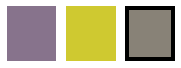

In [ ]:
corpus = dev_corpus.read()

for i in range(3):
  ex = next(corpus)
  ex.display()

In [ ]:
evaluation['predicted_utterance'][: 20]

[['<s>', 'bright', 'purple', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'dark', 'orange', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'red', 'brown', '</s>'],
 ['<s>', 'light', 'blue', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'hot', 'pink', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'bright', 'pink', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'brown', 'brown', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'dark', 'blue', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'bright', 'green', '</s>'],
 ['<s>', 'bright', 'green', '</s>']]

In [ ]:
evaluation['predicted_index'][:10]

[0, 2, 2, 2, 2, 2, 0, 1, 2, 2]

In [ ]:
evaluation['corpus_bleu']

0.700684597275541

In [ ]:
dev_perp = dev_mod_glove.perplexities(dev_cols_test[:10], dev_seqs_test[:10])

In [ ]:
dev_proba = dev_mod_glove.predict_proba(dev_cols_test[:3], dev_seqs_test[:3])

In [ ]:
dev_proba[-1][2][272]
np.argmax(dev_proba[-1][2])
np.max(dev_proba[-1][2])

0.36585212

In [ ]:
dev_perp

[37.15742229528958,
 2.736985973732459,
 5.908272103833246,
 2.7582500057321773,
 28.588934237849926,
 1.8831042058914855,
 2.2072610894038367,
 2.150017552040919,
 1.579783797990838,
 1.5699519481953799]

For the bake-off, we will use our original test set. The function you need to run for the submission is the following, which uses your `evaluate_original_system` from above:

In [ ]:
# This check ensure that the following code only runs on the local environment only.
# The following call will not be run on the autograder environment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    create_bakeoff_submission(dev_mod_glove)